## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [40]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [41]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [42]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = [x.lower() for x in text]
my_text = "".join([x.lower() for x in text])


assert len(my_text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(my_text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

Put all the characters, that you've seen in the text, into variable `tokens`.

In [43]:
# dict <index>:<char>

# dict <char>:<index>
tokens = sorted(set(my_text))
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {j: i for i, j in token_to_idx.items()}
num_tokens = len(tokens)


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [44]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output
from random import sample
from matplotlib import pyplot as plt
from random import sample

In [45]:
train_on_gpu = torch.cuda.is_available()

In [58]:
def to_matrix(text, pad=1): # text - list of words
    text_ix = np.zeros([len(text), MAX_LENGTH]) + pad
    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix

    return text_ix

In [48]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

Plot the loss function (axis X: number of epochs, axis Y: loss function).

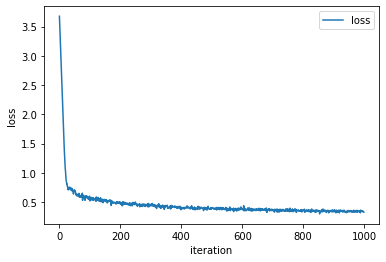

In [75]:
max_iter = 1000
batch_size = 128

MAX_LENGTH = 256

for i in range(max_iter):
    
    batch_ix = to_matrix(sample(text, 128))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)    
    logp_seq = model(batch_ix)
    
    # compute loss
    predictions_logp = F.log_softmax(logp_seq[:, :-1], dim=-1)
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # backpropogation

    loss.backward()
    opt.step()
    opt.zero_grad()
    #<YOUR CODE>

    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.legend()

        plt.show()

In [97]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phraseMAX_LENGTH
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_idx[token.lower()] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    
    #feed the seed phrase, if any
    for i in range(1):
        #print(x_sequence[:, -1].shape)
        out = char_rnn(x_sequence[:, i])
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        out = char_rnn(x_sequence[:, -1, :])
        # Be really careful here with the model output
        p_next = F.softmax(out[:, -1, :] / temperature, dim=-1).data.numpy()[0]
        #print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        #print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix.view((1,1,1))], dim=-1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy().squeeze()])
        

In [98]:
print(generate_sample(model, seed_phrase = ' to be or not', temperature = 0.6, max_length=500))

 to be or not whis sheng arof hor sue neand theres ton thindo dore collese bos mare tore,
                                                                                                                                                                                                                                                                                                                                                                                                                          


In [ ]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

hide my will in thine?
  shall will in of the simend that in my sime the seave the seave the sorll the soren the sange the seall seares and and the fart the wirl the seall the songh whing that thou hall will thoun the soond beare the with that sare the simest me the fart the wirl the songre the with thy seart so for shat so for do the dost the sing the sing the sing the soond canding the sack and the farling the wirl of sore sich and that with the seare the seall so fort the with the past the wirl the simen the wirl the sores the sare


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [99]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.lstm(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits

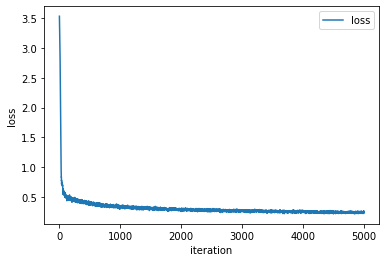

In [104]:
char_lstm = CharLSTMLoop()
opt = torch.optim.Adam(char_lstm.parameters())
history = []

max_iter = 5000
batch_size = 128

for i in range(max_iter):
    batch_ix = to_matrix(sample(text, 128))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)    
    logp_seq = char_lstm(batch_ix)
    
    # compute loss
    predictions_logp = F.log_softmax(logp_seq[:, :-1], dim=-1)
    actual_next_tokens = batch_ix[:, 1:]

    loss = -torch.mean(torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None]))
    
    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.ylabel('loss')
        plt.xlabel('iteration')
        plt.legend()
        plt.show()




Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [105]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for temperature in temperatures:
    generated_text = generate_sample(char_lstm, seed_phrase = ' to be or not', temperature = temperature)
    print ('Temperature = ', temperature, ':', generated_text)

Temperature =  0.1 :  to be or not the seet the seet stane,
                                                                                                                                                                                                                         
Temperature =  0.2 :  to be or not the will the with my stand,
                                                                                                                                                                                                                      
Temperature =  0.5 :  to be or not to the bure of their tate:
                                                                                                                                                                                                                       
Temperature =  1.0 :  to be or notse in doth that my;
                                                                                                                

Well, with temperature 0.1, 0.2, 0.5 text quite OK. But with temperature 1, 2 there is punctuational trash. And it is better than with RNN.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)